In [26]:
import sys
sys.path.append('../cifar10-fast/')

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from core import *
from torch_backend import *

from preact_resnet import PreActResNet18

In [102]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

mu = torch.tensor(cifar10_mean).view(3,1,1).cuda()
std = torch.tensor(cifar10_std).view(3,1,1).cuda()

upper_limit = ((1 - mu)/ std)
lower_limit = ((0 - mu)/ std)

In [3]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [41]:
def show_image(x, figsize, row, col):
    plt.figure(figsize=figsize)
    # 建立一个循环，输出图片
    for i, data in enumerate(x):
    #     设定子图，将每个子图输出到对应的位置
        plt.subplot(row, col, i + 1)
    #     输出图片，取出来的数据是必须处理好再输出的，此例为8*8
        plt.imshow(data)
    #     测试的标题和真实的标题打印出来
    #     plt.title('C:' + str(y_test[i])+'\nT:' + str(y_test[:100][i]), size=20)
    #     关掉x y轴的刻度
        plt.axis('off')
    #     调整每隔子图之间的距离
        plt.tight_layout()

## load data

In [4]:
dataset = cifar10('./cifar-data')

Files already downloaded and verified
Files already downloaded and verified


In [103]:
test_set = list(zip(
    transpose(
        normalise(
            dataset['valid']['data'].astype(np.float32) / 255,
            mean=np.array(cifar10_mean, dtype=np.float32),
            std=np.array(cifar10_std, dtype=np.float32)),
        source='NHWC',
        target='NCHW'),
    dataset['valid']['targets']))

In [104]:
class Batches():
    def __init__(self, dataset, batch_size, shuffle, set_random_choices=False, num_workers=0, drop_last=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.set_random_choices = set_random_choices
        self.dataloader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=shuffle, drop_last=drop_last
        )

    def __iter__(self):
        if self.set_random_choices:
            self.dataset.set_random_choices()
        return ({'input': x.to(device).float(), 'target': y.to(device).long()} for (x,y) in self.dataloader)

    def __len__(self):
        return len(self.dataloader)

In [116]:
batches = Batches(test_set, 100, shuffle=False, num_workers=2)

## load model

In [5]:
model = PreActResNet18()

In [6]:
checkpoint = torch.load('weights/clean_30.pth')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [7]:
model.eval()
model.float()
model = model.cuda()

## 测试准确率

In [117]:
none_total_loss = 0
none_total_acc = 0
none_n = 0

with torch.no_grad():
    for batch in batches:
        X, y = batch['input'], batch['target']
        output = model(X)
        loss = F.cross_entropy(output, y)
        none_total_loss += loss.item() * y.size(0)
        none_total_acc += (output.max(1)[1] == y).sum().item()
        none_n += y.size(0)
        break

print(1.0 * none_total_acc / none_n)

0.95


## 生成对抗样本

In [164]:
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import (LinfFastGradientAttack, LinfBasicIterativeAttack,
                            LinfDeepFoolAttack, L2DeepFoolAttack, L2CarliniWagnerAttack, LinfPGD)
import eagerpy as ep

确认 axis 指向哪里：指向颜色通道 3

In [32]:
imagenet_images, imagenet_labels = ep.astensors(*samples(fmodel, dataset="imagenet", batchsize=16))

In [33]:
imagenet_images.shape

torch.Size([16, 3, 224, 224])

In [145]:
imagenet_labels

PyTorchTensor(tensor([243, 559, 438, 990, 949, 853, 609, 609, 915, 455, 541, 630, 741, 471,
                      129,  99], device='cuda:0'))

准备模型和数据

In [8]:
preprocessing = dict(mean=cifar10_mean, std=cifar10_std, axis=-3)
fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)

In [9]:
images = dataset['valid']['data'].astype(np.float32) / 255
labels = np.array(dataset['valid']['targets'])

images = np.transpose(images, [0, 3, 1, 2])
images = torch.FloatTensor(images).to('cuda:0')
labels = torch.LongTensor(labels).to('cuda:0')

In [35]:
images.shape

torch.Size([10000, 3, 32, 32])

确认封装后模型预测正确性

In [118]:
clean_preds = fmodel(images[:100])
(clean_preds.argmax(1) == labels[:100]).sum()

tensor(95, device='cuda:0')

与上面测试准确率结果一致，说明没问题

### FGSM

In [122]:
fgsm_attack = LinfFastGradientAttack()
fgsm_epsilons = [0.1]
_, fgsm_advs, fgsm_success = fgsm_attack(fmodel, images[:100], labels[:100], epsilons=fgsm_epsilons)

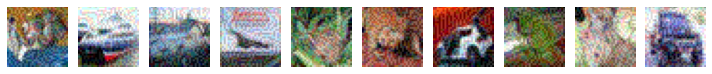

In [123]:
show_image(np.transpose(fgsm_advs[0].cpu(), [0, 2, 3, 1])[:10], (10, 10), 1, 10)

In [124]:
fgsm_success[0].sum()

tensor(92, device='cuda:0')

### BIM

In [131]:
bim_attack = LinfBasicIterativeAttack(abs_stepsize=0.02, steps=10)
bim_epsilons = [0.1]
_, bim_advs, bim_success = bim_attack(fmodel, images[:100], labels[:100], epsilons=bim_epsilons)

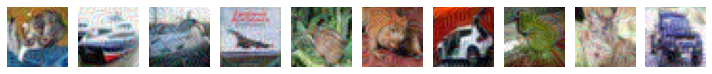

In [132]:
show_image(np.transpose(bim_advs[0].cpu(), [0, 2, 3, 1])[:10], (10, 10), 1, 10)

#### 确认下 success 是怎么计算的

In [134]:
bim_success[0].sum()

tensor(100, device='cuda:0')

adv 预测结果与 true labels 不同？

In [135]:
bim_preds = fmodel(bim_advs[0])

In [136]:
(bim_preds.argmax(1) != labels[:100]).sum()

tensor(100, device='cuda:0')

adv 预测结果与原模型预测结果不同？

In [137]:
(bim_preds.argmax(1) != clean_preds.argmax(1)).sum()

tensor(95, device='cuda:0')

攻击成功数是按照与 true labels 不同的数量来衡量的

### DeepFool

#### L2

In [149]:
from foolbox.criteria import Misclassification

In [156]:
deepfool_attack = L2DeepFoolAttack(steps=50, candidates=10, overshoot=0.02)
deepfool_epsilons = [1.0]
_, deepfool_advs, deepfool_success = deepfool_attack(fmodel, images[:100], labels[:100], epsilons=deepfool_epsilons)

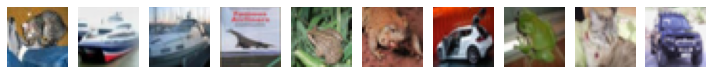

In [157]:
show_image(np.transpose(deepfool_advs[0].cpu(), [0, 2, 3, 1])[:10], (10, 10), 1, 10)

In [158]:
deepfool_success[0].sum()

tensor(100, device='cuda:0')

#### Linf

In [161]:
deepfool_linf_attack = LinfDeepFoolAttack(steps=50, candidates=10, overshoot=0.02)
deepfool_linf_epsilons = [0.1]
_, deepfool_linf_advs, deepfool_linf_success = deepfool_linf_attack(
    fmodel, images[:100], labels[:100], epsilons=deepfool_linf_epsilons)

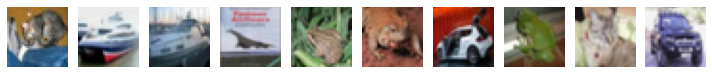

In [162]:
show_image(np.transpose(deepfool_linf_advs[0].cpu(), [0, 2, 3, 1])[:10], (10, 10), 1, 10)

In [163]:
deepfool_linf_success[0].sum()

tensor(100, device='cuda:0')

### C&W

In [165]:
cw_attack = L2CarliniWagnerAttack(binary_search_steps=9, steps=1000, 
                                  stepsize=1e-2, confidence=5, 
                                  initial_const=1e-3, abort_early=True)
cw_epsilons = [1.0]
_, cw_advs, cw_success = cw_attack(fmodel, images[:100], labels[:100], epsilons=cw_epsilons)

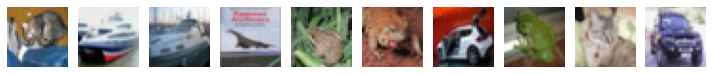

In [166]:
show_image(np.transpose(cw_advs[0].cpu(), [0, 2, 3, 1])[:10], (10, 10), 1, 10)

In [167]:
cw_success[0].sum()

tensor(100, device='cuda:0')

### PGD

In [168]:
pgd_attack = LinfPGD()
pgd_epsilons = [0.1, 0.3]
_, pgd_advs, pgd_success = attack(fmodel, images[:100], labels[:100], epsilons=pgd_epsilons)

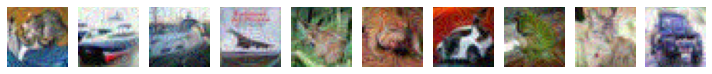

In [169]:
show_image(np.transpose(pgd_advs[0].cpu(), [0, 2, 3, 1])[:10], (10, 10), 1, 10)

In [31]:
list(range(5, 55,5))

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50]